In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import re

2023-03-17 16:19:58.342270: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load data

In [3]:
df = pd.read_csv('./cow.csv')
df

,surgery,age,hospital_number,temperature,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,outcome Class,surgical_lesion,lesion
0,no,adult,530101,38.5,66.0,28.0,cool,reduced,NaN,more_3_sec,...,NaN,decreased,distend_large,45.0,8.4,NaN,NaN,died,no,11300
1,yes,adult,534817,39.2,88.0,20.0,NaN,NaN,pale_cyanotic,less_3_sec,...,NaN,absent,other,50.0,85.0,cloudy,2.0,euthanized,no,2208
2,no,adult,530334,38.3,40.0,24.0,normal,normal,pale_pink,less_3_sec,...,NaN,normal,normal,33.0,6.7,NaN,NaN,lived,no,0
3,yes,young,5290409,39.1,164.0,84.0,cold,normal,dark_cyanotic,more_3_sec,...,5.0,decreased,NaN,48.0,7.2,serosanguious,5.3,died,yes,2208
4,no,adult,530255,37.3,104.0,35.0,NaN,NaN,dark_cyanotic,more_3_sec,...,NaN,NaN,NaN,74.0,7.4,NaN,NaN,died,no,4300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,yes,adult,533886,NaN,120.0,70.0,cold,NaN,pale_cyanotic,more_3_sec,...,NaN,NaN,distend_large,55.0,65.0,NaN,NaN,euthanized,no,3205
295,no,adult,527702,37.2,72.0,24.0,cool,increased,pale_cyanotic,more_3_sec,...,NaN,absent,distend_small,44.0,NaN,serosanguious,3.3,euthanized,yes,2208
296,yes,adult,529386,37.5,72.0,30.0,cold,reduced,pale_cyanotic,less_3_sec,...,NaN,decreased,distend_large,60.0,6.8,NaN,NaN,died,yes,3205
297,yes,adult,530612,36.5,100.0,24.0,cool,reduced,pale_pink,less_3_sec,...,NaN,absent,distend_small,50.0,6.0,serosanguious,3.4,lived,yes,2208


In [4]:
def extract_lesion_column(lesion):
    site, type_l, subtype, code = 'None', 'None', 'None', 'None'
    if lesion != 0:
        types = re.findall('^([1-9]|11|00)([1-4])([0-2])([1-9]|10|0)',str(lesion))
        if types:
            site, type_l, subtype, code = types[0]
    return pd.Series({'lesion_site': site, 'lesion_type': type_l, 'lesion_subtype': subtype, 'lesion_code': code}, dtype='category')

df.loc[:, ['lesion_site', 'lesion_type', 'lesion_subtype', 'lesion_code']] = df.lesion.apply(extract_lesion_column).astype('category')
df.drop(columns=['lesion', 'hospital_number'], inplace=True)

In [5]:
categorical_columns = []
for col in df:
    if str(df[col].dtype) != 'category' and df[col].unique().size < 10:
        df[col].fillna('[NAN]', inplace=True)
        categorical_columns.append(col)
        df[col] = df[col].astype('category')

In [6]:
X = []
X_labels = []
Y = None
for col in df:
    if col == 'outcome Class':
        Y = df[col].cat.codes.values
    elif str(df[col].dtype) != 'category':
        X.append(df[col].fillna(df[col].mean()).values,)
        X_labels.append(col)
    else:
        X.append(df[col].cat.codes.values)
        X_labels.append(col)
X = np.array(X).T
x_label2idx = {l:i for i,l in enumerate(X_labels)}

In [7]:
col2types = {l:df[l].dtype.name for l in X_labels}

In [8]:
def build_model():
    def _build_input_layer(feature_name):
        if col2types[feature_name] == 'category':
            inputs = tf.keras.layers.Input(shape=(1,), name=feature_name)
            n = np.unique(X[:, x_label2idx[feature_name]]).size
            x = tf.keras.layers.Embedding(n, 128, input_length=1)(inputs)
            x = tf.keras.layers.Flatten()(x)
            x = tf.keras.layers.Dense(128)(inputs)
            return inputs, x
        else:
            inputs = tf.keras.layers.Input(shape=(1,), name=feature_name)
            x = tf.keras.layers.Dense(128)(inputs)
            return inputs, x

    in_layers = []
    x_layers = []
    for feature in keep_cols_label:
        il, xl = _build_input_layer(feature)
        in_layers.append(il)
        x_layers.append(xl)

    x = tf.keras.layers.Concatenate()(x_layers)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Average()(x_layers + [x])
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dense(num_classes, activation='softmax', name='prediction')(x)
    return tf.keras.Model(inputs=in_layers, outputs=x, name='model')

In [9]:
import sklearn.feature_selection as fs
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [10]:
selector = fs.SelectPercentile(fs.f_classif,percentile=15).fit(X, Y)
X_new = selector.transform(X)
keep_cols = selector.scores_.argsort()[::-1][:X_new.shape[1]]
keep_cols_label = [X_labels[i] for i in keep_cols]
keep_cols_label

['lesion_subtype', 'packed_cell_volume', 'total_protein', 'lesion_site']

In [11]:
x_train_, x_test_, y_train_, y_test_ = train_test_split(X[:,keep_cols], Y, test_size=0.2)

In [12]:
y_train = tf.keras.utils.to_categorical(y_train_)
y_test = tf.keras.utils.to_categorical(y_test_)

In [13]:
num_classes = np.unique(y_test_).size
num_classes

3

In [14]:
outcome_classes = df['outcome Class'].cat.categories.tolist() # ['died', 'euthanized', 'lived']

In [20]:
def build_and_fit_model(feature_selector, epochs=50):
    X_new = selector.transform(X)
    keep_cols = selector.scores_.argsort()[::-1][:X_new.shape[1]]
    keep_cols_label = [X_labels[i] for i in keep_cols]
    
    x_train = {l:v for l, v in zip(keep_cols_label, x_train_.T)}
    x_test = {l:v for l, v in zip(keep_cols_label, x_test_.T)}
    
    y_train = tf.keras.utils.to_categorical(y_train_)
    y_test = tf.keras.utils.to_categorical(y_test_)

    model = build_model()
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.categorical_crossentropy,
        metrics=['accuracy', tf.keras.metrics.Recall()]
    )
    
    fit_history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50)
    
    for k, v in fit_history.history.items():
        if 'recall' in k:
            plt.plot(v, label=k)
        plt.legend()
        
    model.evaluate(x_test, y_test)
    y_preds = model.predict(x_test).argmax(1)
    
    print(classification_report(y_test.argmax(1), y_preds, target_names=outcome_classes))
    
    ConfusionMatrixDisplay(
        confusion_matrix(y_test.argmax(1), y_preds),display_labels=outcome_classes
    ).plot(xticks_rotation=45)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 lesion_subtype (InputLayer)    [(None, 1)]          0           []                               
                                                                                                  
 packed_cell_volume (InputLayer  [(None, 1)]         0           []                               
 )                                                                                                
                                                                                                  
 total_protein (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 lesion_site (InputLayer)       [(None, 1)]          0           []                           

8/8 [==============================] - 0s 7ms/step - loss: 0.6763 - accuracy: 0.7113 - recall_4: 0.6402 - val_loss: 0.7443 - val_accuracy: 0.6333 - val_recall_4: 0.6333
Epoch 25/50
8/8 [==============================] - 0s 8ms/step - loss: 0.7100 - accuracy: 0.7071 - recall_4: 0.6904 - val_loss: 0.7132 - val_accuracy: 0.6667 - val_recall_4: 0.6667
Epoch 26/50
8/8 [==============================] - 0s 7ms/step - loss: 0.6616 - accuracy: 0.7573 - recall_4: 0.6820 - val_loss: 0.6789 - val_accuracy: 0.6667 - val_recall_4: 0.6667
Epoch 27/50
8/8 [==============================] - 0s 7ms/step - loss: 0.6395 - accuracy: 0.7448 - recall_4: 0.7113 - val_loss: 0.6666 - val_accuracy: 0.6667 - val_recall_4: 0.6667
Epoch 28/50
8/8 [==============================] - 0s 7ms/step - loss: 0.6441 - accuracy: 0.7280 - recall_4: 0.6862 - val_loss: 0.6807 - val_accuracy: 0.6833 - val_recall_4: 0.6833
Epoch 29/50
8/8 [==============================] - 0s 7ms/step - loss: 0.6347 - accuracy: 0.7406 - recall_4

No handles with labels found to put in legend.
No handles with labels found to put in legend.


2/2 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

        died       0.32      0.88      0.47         8
  euthanized       0.75      0.30      0.43        10
       lived       0.88      0.71      0.79        42

    accuracy                           0.67        60
   macro avg       0.65      0.63      0.56        60
weighted avg       0.79      0.67      0.69        60



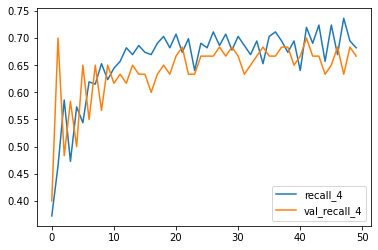

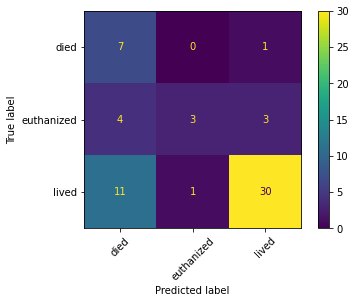

In [21]:
build_and_fit_model(fs.SelectPercentile(fs.f_classif,percentile=10).fit(X, Y))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 lesion_subtype (InputLayer)    [(None, 1)]          0           []                               
                                                                                                  
 packed_cell_volume (InputLayer  [(None, 1)]         0           []                               
 )                                                                                                
                                                                                                  
 total_protein (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 lesion_site (InputLayer)       [(None, 1)]          0           []                           

8/8 [==============================] - 0s 8ms/step - loss: 0.6561 - accuracy: 0.7448 - recall_5: 0.6904 - val_loss: 0.7503 - val_accuracy: 0.6500 - val_recall_5: 0.6333
Epoch 25/50
8/8 [==============================] - 0s 7ms/step - loss: 0.6580 - accuracy: 0.6987 - recall_5: 0.6569 - val_loss: 0.6604 - val_accuracy: 0.6500 - val_recall_5: 0.6167
Epoch 26/50
8/8 [==============================] - 0s 7ms/step - loss: 0.6447 - accuracy: 0.7490 - recall_5: 0.6653 - val_loss: 0.8903 - val_accuracy: 0.6167 - val_recall_5: 0.6000
Epoch 27/50
8/8 [==============================] - 0s 8ms/step - loss: 0.7068 - accuracy: 0.6778 - recall_5: 0.6192 - val_loss: 0.6493 - val_accuracy: 0.7167 - val_recall_5: 0.6000
Epoch 28/50
8/8 [==============================] - 0s 8ms/step - loss: 0.6893 - accuracy: 0.6904 - recall_5: 0.6485 - val_loss: 0.8619 - val_accuracy: 0.6333 - val_recall_5: 0.6000
Epoch 29/50
8/8 [==============================] - 0s 9ms/step - loss: 0.6805 - accuracy: 0.7197 - recall_5

No handles with labels found to put in legend.
No handles with labels found to put in legend.


2/2 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

        died       0.30      0.88      0.45         8
  euthanized       0.62      0.50      0.56        10
       lived       0.97      0.67      0.79        42

    accuracy                           0.67        60
   macro avg       0.63      0.68      0.60        60
weighted avg       0.82      0.67      0.70        60



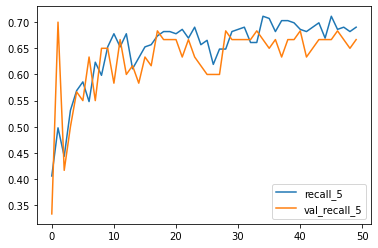

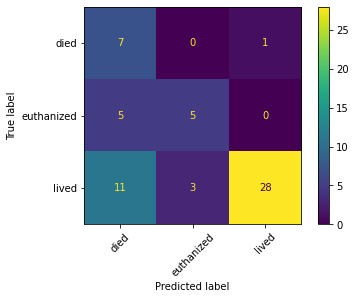

In [22]:
build_and_fit_model(fs.SelectPercentile(fs.f_classif,percentile=50).fit(X, Y))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 lesion_subtype (InputLayer)    [(None, 1)]          0           []                               
                                                                                                  
 packed_cell_volume (InputLayer  [(None, 1)]         0           []                               
 )                                                                                                
                                                                                                  
 total_protein (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 lesion_site (InputLayer)       [(None, 1)]          0           []                           

8/8 [==============================] - 0s 8ms/step - loss: 0.6486 - accuracy: 0.7322 - recall_6: 0.7113 - val_loss: 0.6867 - val_accuracy: 0.6833 - val_recall_6: 0.6833
Epoch 25/50
8/8 [==============================] - 0s 7ms/step - loss: 0.6482 - accuracy: 0.7364 - recall_6: 0.6987 - val_loss: 0.6901 - val_accuracy: 0.6667 - val_recall_6: 0.6667
Epoch 26/50
8/8 [==============================] - 0s 8ms/step - loss: 0.6423 - accuracy: 0.7406 - recall_6: 0.7071 - val_loss: 0.7106 - val_accuracy: 0.6833 - val_recall_6: 0.6833
Epoch 27/50
8/8 [==============================] - 0s 7ms/step - loss: 0.6412 - accuracy: 0.7531 - recall_6: 0.7113 - val_loss: 0.7243 - val_accuracy: 0.6667 - val_recall_6: 0.6667
Epoch 28/50
8/8 [==============================] - 0s 7ms/step - loss: 0.6465 - accuracy: 0.7364 - recall_6: 0.6987 - val_loss: 0.6410 - val_accuracy: 0.6667 - val_recall_6: 0.6667
Epoch 29/50
8/8 [==============================] - 0s 7ms/step - loss: 0.6531 - accuracy: 0.7322 - recall_6

No handles with labels found to put in legend.
No handles with labels found to put in legend.


2/2 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

        died       0.30      0.88      0.45         8
  euthanized       0.80      0.40      0.53        10
       lived       0.94      0.71      0.81        42

    accuracy                           0.68        60
   macro avg       0.68      0.66      0.60        60
weighted avg       0.83      0.68      0.72        60



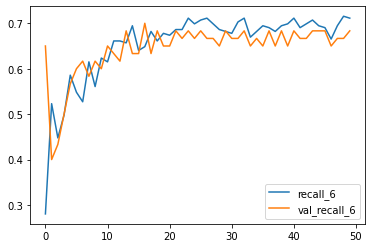

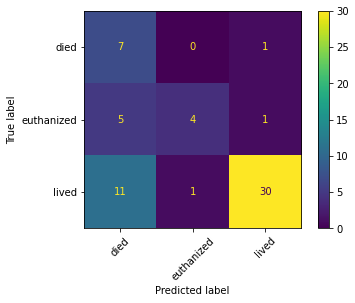

In [23]:
build_and_fit_model(fs.SelectPercentile(fs.f_classif,percentile=100).fit(X, Y))